In [15]:
import sys

assert sys.version_info >= (3, 7)
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"
import tf_keras
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
from pathlib import Path
import matplotlib.pyplot as plt

IMAGES_PATH = Path() / "images" / "generative"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


# 1-Forward Process

In [16]:
import matplotlib as plt

In [17]:
import tensorflow as tf

In [18]:
import numpy as np

In [19]:
# extra code – loads, scales, and splits the fashion MNIST dataset
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [20]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

# Variance Scheduler (Producing Noise at different time steps)

In [44]:
def variance_schedule(T, s=0.008, max_beta=0.999):
    t = np.arange(T + 1)
    f = np.cos((t / T + s) / (1 + s) * np.pi / 2) ** 2
    alpha = np.clip(f[1:] / f[:-1], 1 - max_beta, 1)
    alpha = np.append(1, alpha).astype(np.float32)  # add α₀ = 1
    beta = 1 - alpha
    alpha_cumprod = np.cumprod(alpha)
    return alpha, alpha_cumprod, beta  # αₜ , α̅ₜ , βₜ for t = 0 to T

np.random.seed(42)  # extra code – for reproducibility
T = 5500
alpha, alpha_cumprod, beta = variance_schedule(T)

# Preparing Dataset

# Prepare Inputs to model , which are Noisy inputs and time which noise was added to raw input in the markov-chain process

In [45]:
def prepare_batch(X):
    X = tf.cast(X[..., tf.newaxis], tf.float32) * 2 - 1  # scale from –1 to +1
    X_shape = tf.shape(X)
    t = tf.random.uniform([X_shape[0]], minval=1, maxval=T + 1, dtype=tf.int32)
    alpha_cm = tf.gather(alpha_cumprod, t)
    alpha_cm = tf.reshape(alpha_cm, [X_shape[0]] + [1] * (len(X_shape) - 1))
    noise = tf.random.normal(X_shape)
    return {
        "X_noisy": alpha_cm ** 0.5 * X + (1 - alpha_cm) ** 0.5 * noise,
        "time": t,
    }, noise

In [46]:
def prepare_dataset(X, batch_size=32, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices(X)
    if shuffle:
        ds = ds.shuffle(10_000)
    return ds.batch(batch_size).map(prepare_batch).prefetch(1)

tf.random.set_seed(43)  # extra code – ensures reproducibility on CPU
train_set = prepare_dataset(X_train, batch_size=32, shuffle=True)
valid_set = prepare_dataset(X_valid, batch_size=32)

# Helper functions

In [47]:

def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

Original images


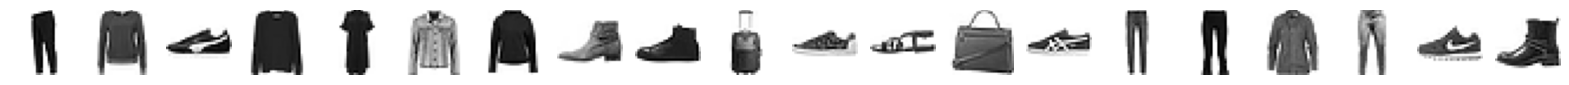

Time steps: [1405 5312 3941 3491 3443 3157 4308 3651 4034 5038 1000 2009 3543 1932
 1274 2742  585 4431 1331 2564]
Noisy images


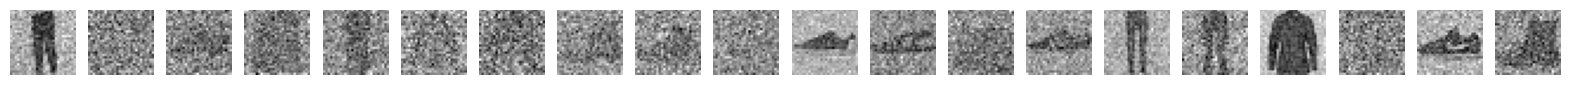

Noise to predict


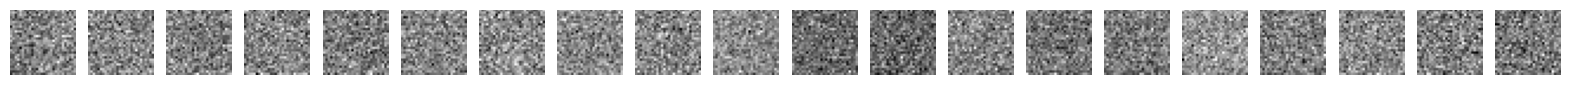

In [48]:
# extra code – just a quick sanity check
import matplotlib.pyplot as plt

def subtract_noise(X_noisy, time, noise):
    X_shape = tf.shape(X_noisy)
    alpha_cm = tf.gather(alpha_cumprod, time)
    alpha_cm = tf.reshape(alpha_cm, [X_shape[0]] + [1] * (len(X_shape) - 1))
    return (X_noisy - (1 - alpha_cm) ** 0.5 * noise) / alpha_cm ** 0.5

X_dict, Y_noise = list(train_set.take(1))[0]  # get the first batch
X_original = subtract_noise(X_dict["X_noisy"], X_dict["time"], Y_noise)

print("Original images")
plot_multiple_images(X_original[:20].numpy())
plt.show()
print("Time steps:", X_dict["time"].numpy()[:20])
print("Noisy images")
plot_multiple_images(X_dict["X_noisy"][:20].numpy())
plt.show()
print("Noise to predict")
plot_multiple_images(Y_noise[:20].numpy())
plt.show()

# Time Encoding

In [49]:
# extra code – implements a custom time encoding layer

embed_size = 64

class TimeEncoding(tf.keras.layers.Layer):
    def __init__(self, T, embed_size, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        assert embed_size % 2 == 0, "embed_size must be even"
        p, i = np.meshgrid(np.arange(T + 1), 2 * np.arange(embed_size // 2))
        t_emb = np.empty((T + 1, embed_size))
        t_emb[:, ::2] = np.sin(p / 10_000 ** (i / embed_size)).T
        t_emb[:, 1::2] = np.cos(p / 10_000 ** (i / embed_size)).T
        self.time_encodings = tf.constant(t_emb.astype(self.dtype))

    def call(self, inputs):
        return tf.gather(self.time_encodings, inputs)

# U-NET Model Implementation

In [50]:
def build_diffusion_model():
    X_noisy = tf.keras.layers.Input(shape=[28, 28, 1], name="X_noisy")
    time_input = tf.keras.layers.Input(shape=[], dtype=tf.int32, name="time")
    time_enc = TimeEncoding(T, embed_size)(time_input)

    dim = 16
    Z = tf.keras.layers.ZeroPadding2D((3, 3))(X_noisy)
    Z = tf.keras.layers.Conv2D(dim, 3)(Z)
    Z = tf.keras.layers.BatchNormalization()(Z)
    Z = tf.keras.layers.Activation("relu")(Z)

    time = tf.keras.layers.Dense(dim)(time_enc)  # adapt time encoding
    Z = time[:, tf.newaxis, tf.newaxis, :] + Z  # add time data to every pixel

    skip = Z
    cross_skips = []  # skip connections across the down & up parts of the UNet

    for dim in (32, 64, 128):
        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.SeparableConv2D(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.SeparableConv2D(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        cross_skips.append(Z)
        Z = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(Z)
        skip_link = tf.keras.layers.Conv2D(dim, 1, strides=2,
                                           padding="same")(skip)
        Z = tf.keras.layers.add([Z, skip_link])

        time = tf.keras.layers.Dense(dim)(time_enc)
        Z = time[:, tf.newaxis, tf.newaxis, :] + Z
        skip = Z

    for dim in (64, 32, 16):
        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.Conv2DTranspose(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        Z = tf.keras.layers.Activation("relu")(Z)
        Z = tf.keras.layers.Conv2DTranspose(dim, 3, padding="same")(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)

        Z = tf.keras.layers.UpSampling2D(2)(Z)

        skip_link = tf.keras.layers.UpSampling2D(2)(skip)
        skip_link = tf.keras.layers.Conv2D(dim, 1, padding="same")(skip_link)
        Z = tf.keras.layers.add([Z, skip_link])

        time = tf.keras.layers.Dense(dim)(time_enc)
        Z = time[:, tf.newaxis, tf.newaxis, :] + Z
        Z = tf.keras.layers.concatenate([Z, cross_skips.pop()], axis=-1)
        skip = Z

    outputs = tf.keras.layers.Conv2D(1, 3, padding="same")(Z)[:, 2:-2, 2:-2]
    return tf.keras.Model(inputs=[X_noisy, time_input], outputs=[outputs])

In [51]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on the CPU
model = build_diffusion_model()
model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.Nadam())

# extra code – adds a ModelCheckpoint callback
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_diffusion_model.keras",
                                                   save_best_only=True)

history = model.fit(train_set, validation_data=valid_set, epochs=100,
                    callbacks=[checkpoint_cb])  # extra code

Epoch 1/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 65s 21ms/step - loss: 0.1616 - val_loss: 0.0683
Epoch 2/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 0.0623 - val_loss: 0.0527
Epoch 3/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 0.0520 - val_loss: 0.0492
Epoch 4/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 0.0485 - val_loss: 0.0476
Epoch 5/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 0.0465 - val_loss: 0.0453
Epoch 6/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - loss: 0.0450 - val_loss: 0.0444
Epoch 7/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 0.0441 - val_loss: 0.0438
Epoch 8/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 0.0433 - val_loss: 0.0435
Epoch 9/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 0.0427 - val_loss: 0.0427
Epoch 10/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 0.0422 - val_loss: 0.0421
Epoch 11/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - loss: 0.0420 - val_loss: 0.04

# Inference Stage of Diffusion Model

In [52]:
def generate(model, batch_size=32):
    X = tf.random.normal([batch_size, 28, 28, 1])
    for t in range(T - 1, 0, -1):
        print(f"\rt = {t}", end=" ")  # extra code – show progress
        noise = (tf.random.normal if t > 1 else tf.zeros)(tf.shape(X))
        X_noise = model({"X_noisy": X, "time": tf.constant([t] * batch_size)})
        X = (
            1 / alpha[t] ** 0.5
            * (X - beta[t] / (1 - alpha_cumprod[t]) ** 0.5 * X_noise)
            + (1 - alpha[t]) ** 0.5 * noise
        )
    return X

tf.random.set_seed(42)  # extra code – ensures reproducibility on the CPU
X_gen = generate(model)  # generated images

t = 1 

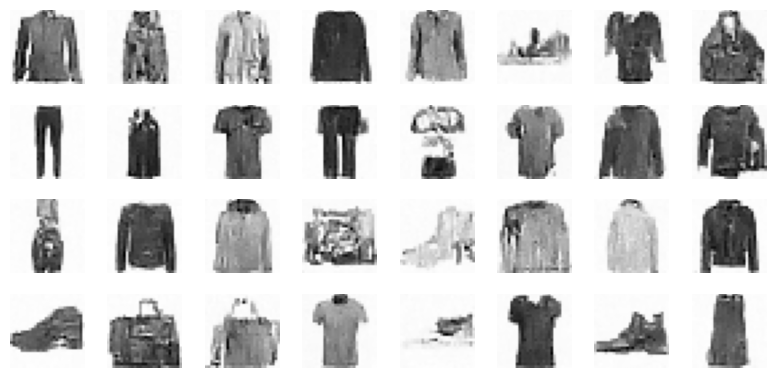

In [53]:
plot_multiple_images(X_gen.numpy(), 8)
save_fig("ddpm_generated_images_plot")
plt.show()